# What is this notebook about

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d


from astropy.stats import median_absolute_deviation as MAD


In [2]:
# #plots layout
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [3]:
folder = "Data/Additional_EIRPs"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
data = {}

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    # Store in the dictionary
    data[label] = df

In [4]:
temp_df = data['Kiricom_Radio_On_MAX_100kHz_EIRP']
temp_df.columns

Index(['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)'], dtype='object')

In [5]:
for instrument_name, df in data.items():
    print(f"\nColumns in {instrument_name}:")
    print(df.columns.tolist())


Columns in Kiricom_Radio_On_MAX_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in Superfire_HL58_Headlamp_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in ALS_Bakkie_CAA567123_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in 2020_02_11_INCA_Camera_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']


/tmp/ipykernel_3791/2337824273.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


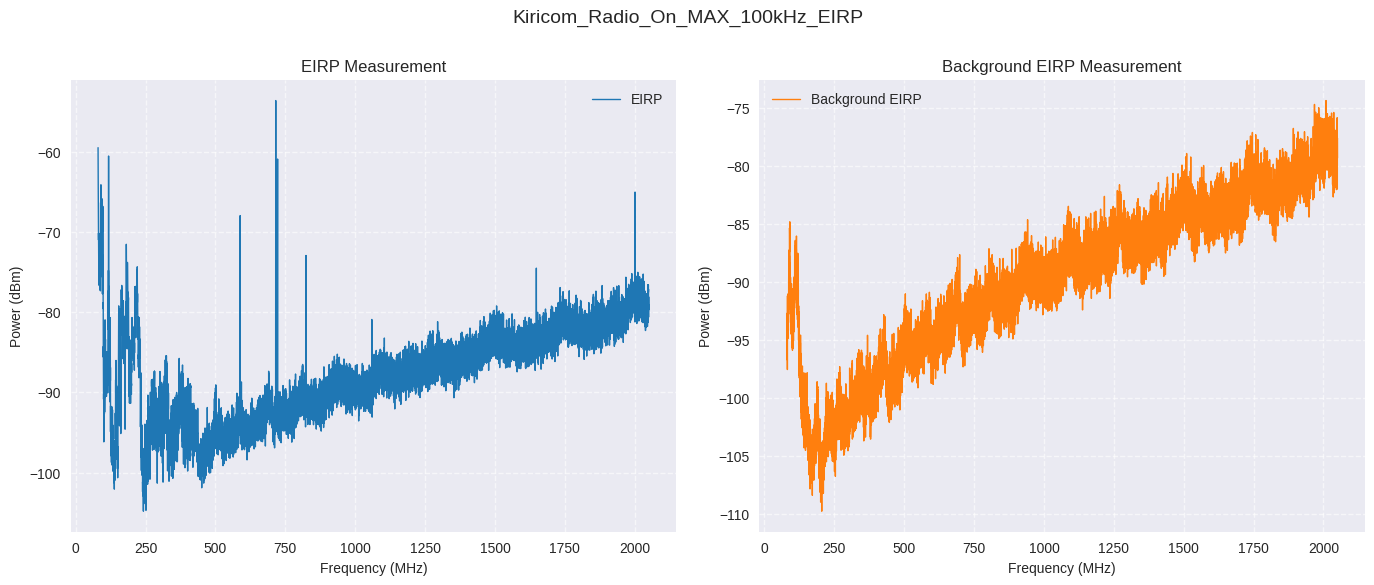

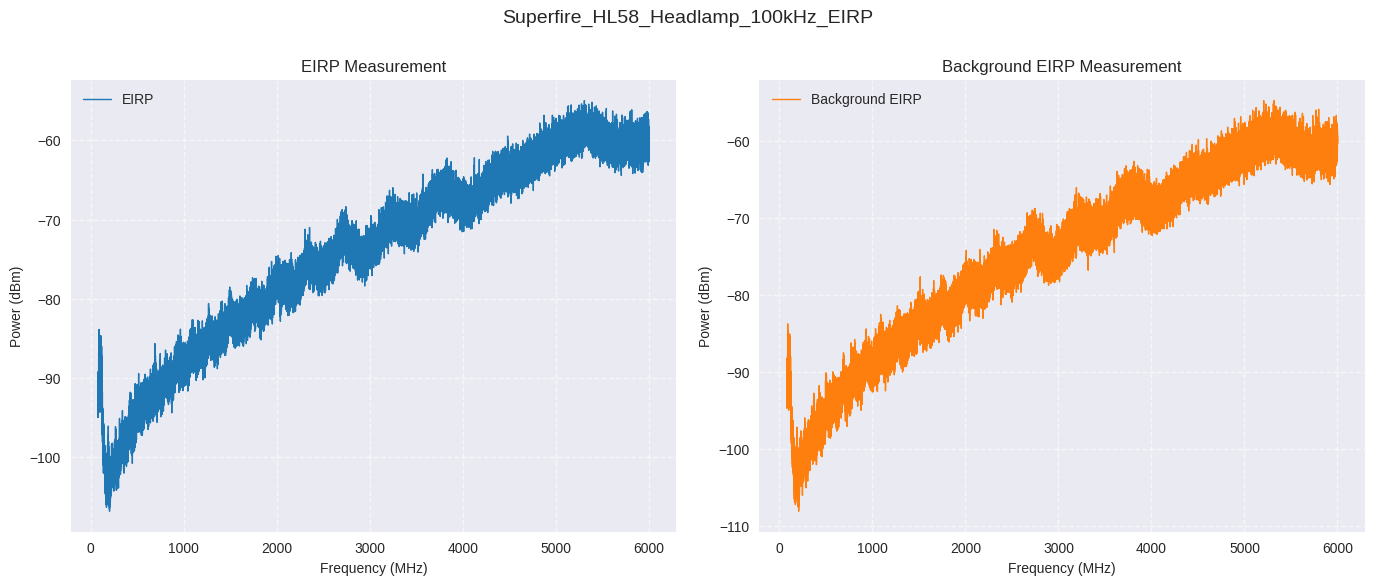

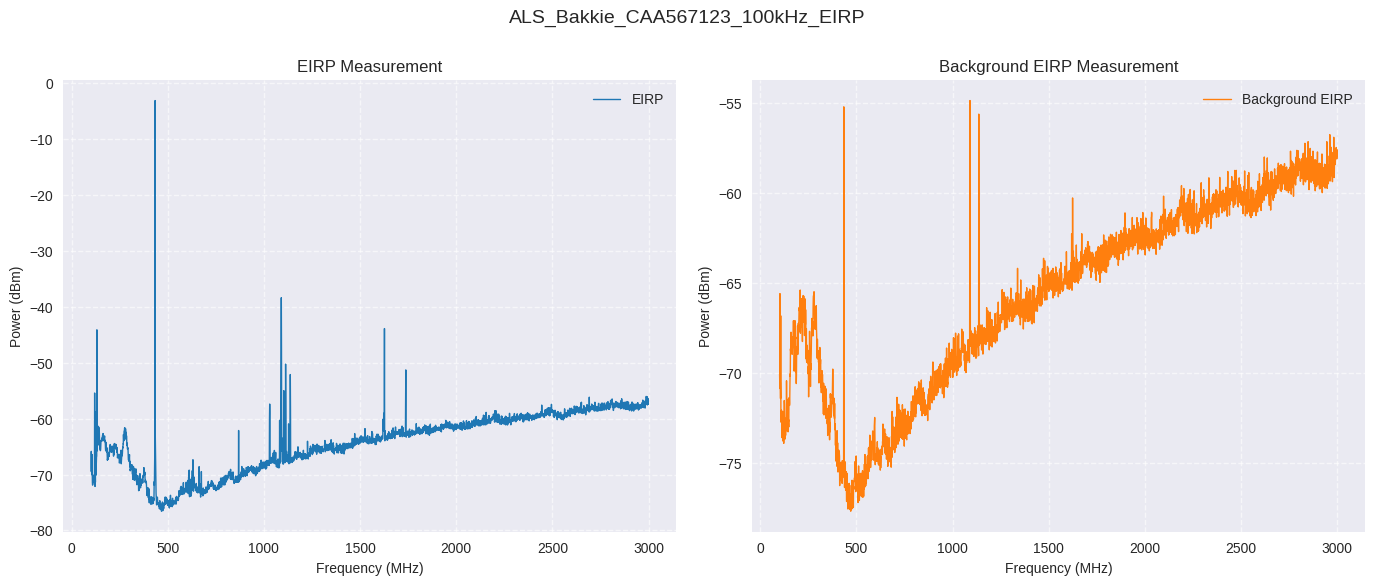

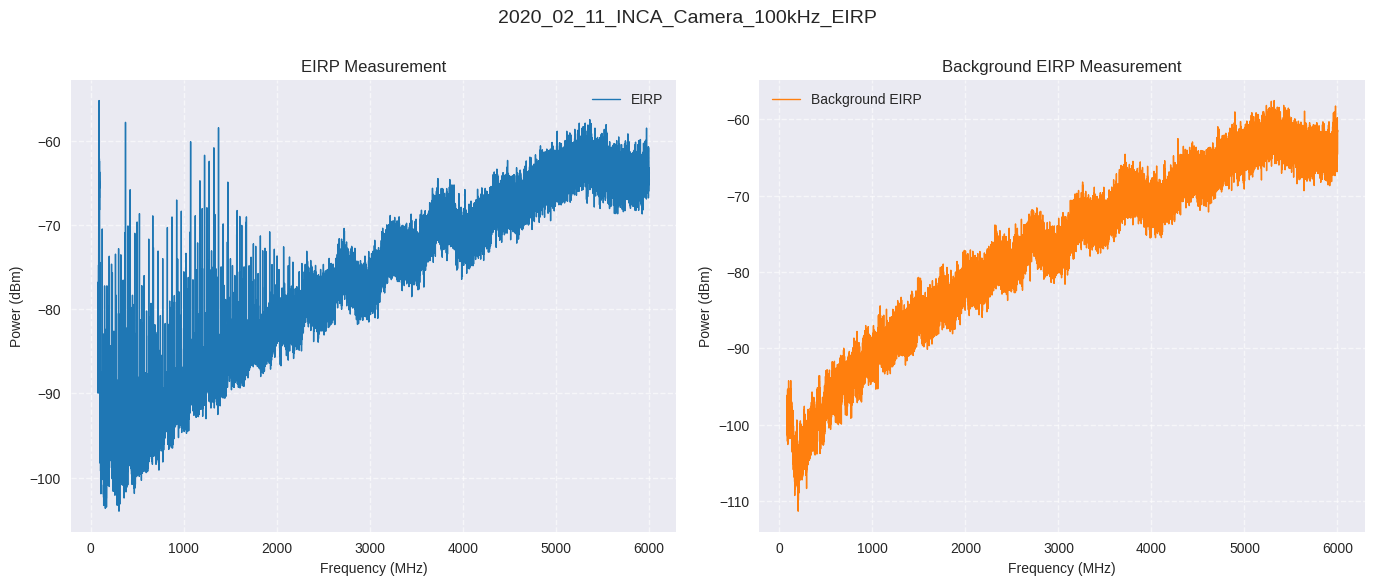

In [6]:
# Set style for better visual appearance
plt.style.use('seaborn')

for instrument_name, data_plot in data.items():
    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{instrument_name}', fontsize=14)
    
    # Plot EIRP data
    axs[0].plot(data_plot['Frequency(MHz)'], data_plot['EIRP(dBm)'], 
               color='tab:blue', linewidth=1, label='EIRP')
    axs[0].set_xlabel('Frequency (MHz)', fontsize=10)
    axs[0].set_ylabel('Power (dBm)', fontsize=10)
    axs[0].set_title('EIRP Measurement', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].legend()
    
    # Plot Background EIRP data
    axs[1].plot(data_plot['Frequency(MHz)'], data_plot['BG_EIRP(dBm)'], 
               color='tab:orange', linewidth=1, label='Background EIRP')
    axs[1].set_xlabel('Frequency (MHz)', fontsize=10)
    axs[1].set_ylabel('Power (dBm)', fontsize=10)
    axs[1].set_title('Background EIRP Measurement', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [7]:
camera = data['2020_02_11_INCA_Camera_100kHz_EIRP']
bakkie = data['ALS_Bakkie_CAA567123_100kHz_EIRP']
radio = data['Kiricom_Radio_On_MAX_100kHz_EIRP']
headlamp = data['Superfire_HL58_Headlamp_100kHz_EIRP']

bakkie.items

<bound method DataFrame.items of       Frequency(MHz)  EIRP(dBm)  BG_EIRP(dBm)
0         100.440000 -69.390840    -70.060840
1         101.413333 -69.248062    -70.638062
2         102.386667 -65.854705    -65.594705
3         103.360000 -68.839424    -70.869424
4         104.333333 -69.714813    -70.534813
...              ...        ...           ...
2974     2995.133333 -56.694552    -57.594552
2975     2996.106667 -56.376291    -57.566291
2976     2997.080000 -56.398307    -58.108307
2977     2998.053333 -57.430704    -57.610704
2978     2999.026667 -57.264256    -57.974256

[2979 rows x 3 columns]>

# Remove the back groud signal 

To remove the back-group noite:
1. convert the measurements form (dBm) to mW, i.e, from log-scale for liner scale.
2. perfome the substraction of the back-groud 
3. convert back to log scale

In [8]:
def bg_remove(signal, background):
     """
    Args:
    signal: mesurements of the instrument + noise
    background: mesurement of the background

    Return:
    clean_signal: signal of the instrument
    """
     
    # convert log scale to linear scale
     signal_mW = 10**(signal/10)
     background_mW = 10**(background/10)

    # Subtract background in linear scale
     clean_mW = signal_mW - background_mW
     clean_mW[clean_mW <= 0] = np.nan

    # Convert back to dBm
     clean_signal = 10 * np.log10(clean_mW)
     
     print(type(clean_signal))

     return clean_signal



In [9]:
!pwd

/home/garces/Desktop/Master


/tmp/ipykernel_3791/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


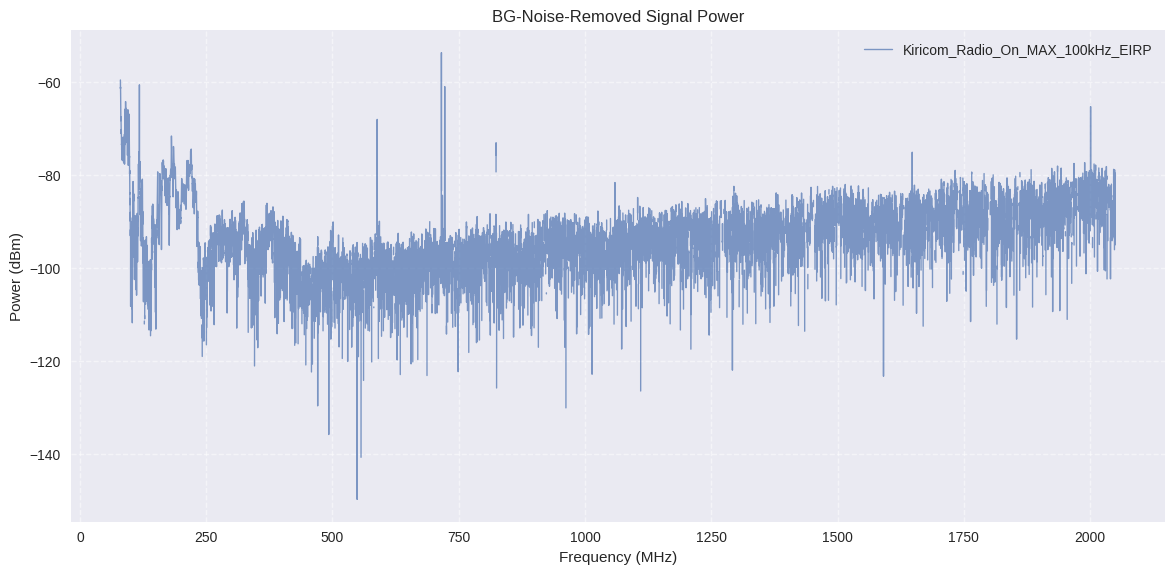

/tmp/ipykernel_3791/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


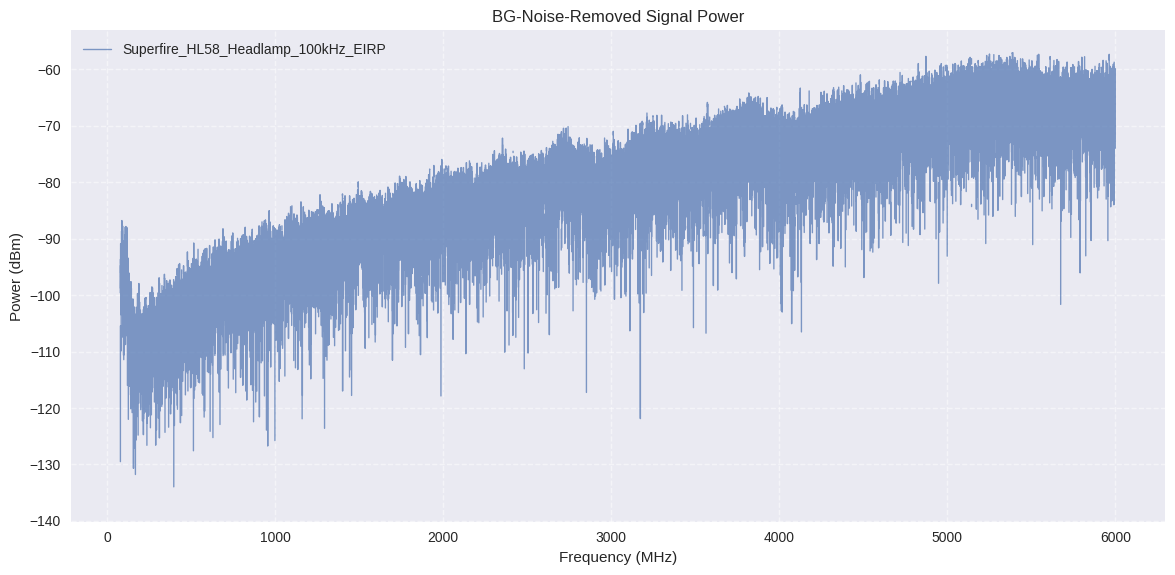

/tmp/ipykernel_3791/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


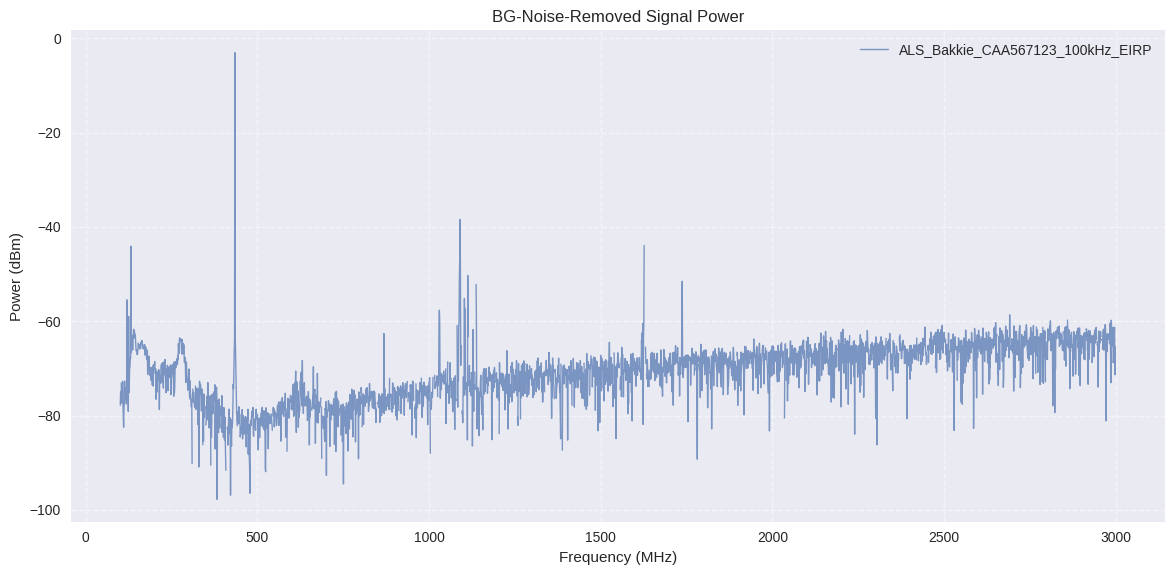

/tmp/ipykernel_3791/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


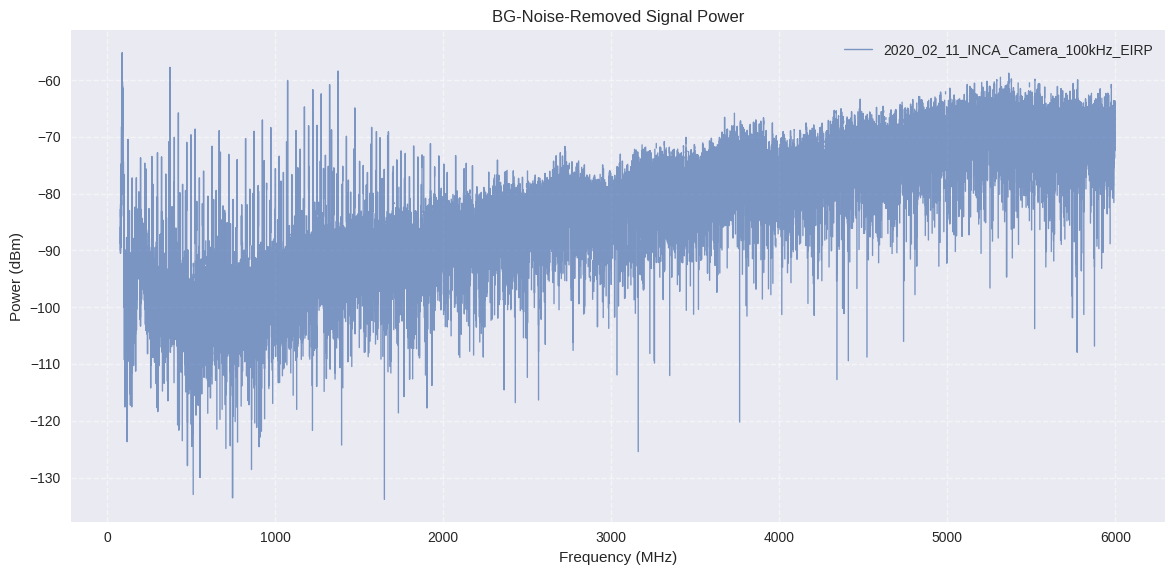

In [10]:


for instrument_name, df in data.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))


    clean_signal = bg_remove(df['EIRP(dBm)'], df['BG_EIRP(dBm)'])

    # # save to a dataframe
    # clean_instrument = {'Frequency (MHz)': df['Frequency(MHz)'],
    #               'Clean_EIRP(dBm)': clean_signal}
    # dataframe = pd.DataFrame(clean_instrument)
    # dataframe.to_csv(f'Data/Data_cleaned/{instrument_name}.csv')
    
    

    # Plot with proper labels
    plt.plot(df['Frequency(MHz)'], clean_signal, 
             label=instrument_name, 
             alpha=0.7,
             linewidth=1)
    

    # Format plot
    plt.title('BG-Noise-Removed Signal Power')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Power (dBm)')
    #plt.xlim(50,350)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Read all clean data

In [11]:
folder = "Data/Data_cleaned"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
dataframe_clean = {}
labels = []

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    labels.append(label)

    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    #drop any row with missing values in this file only
    df = df.dropna().reset_index(drop=True)


    # # Store in the dictionary
    dataframe_clean[label] = df

dataframe_clean

{'Kiricom_Radio_On_MAX_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               0          80.0925       -59.478259
 1               1          80.1850       -61.157473
 2               2          80.2775       -61.318212
 3               3          80.3700       -60.994273
 4               4          80.4625       -61.422765
 ...           ...              ...              ...
 12797       21291        2049.5100       -87.196076
 12798       21292        2049.6025       -84.371832
 12799       21294        2049.7875       -86.330525
 12800       21295        2049.8800       -94.942077
 12801       21296        2049.9725       -92.431921
 
 [12802 rows x 3 columns],
 'Superfire_HL58_Headlamp_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               1          80.0925      -105.448569
 1               2          80.1850      -129.491156
 2               5          80.4625       -98.770357
 3               6          80.5550       -93.65

/tmp/ipykernel_3791/9437385.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


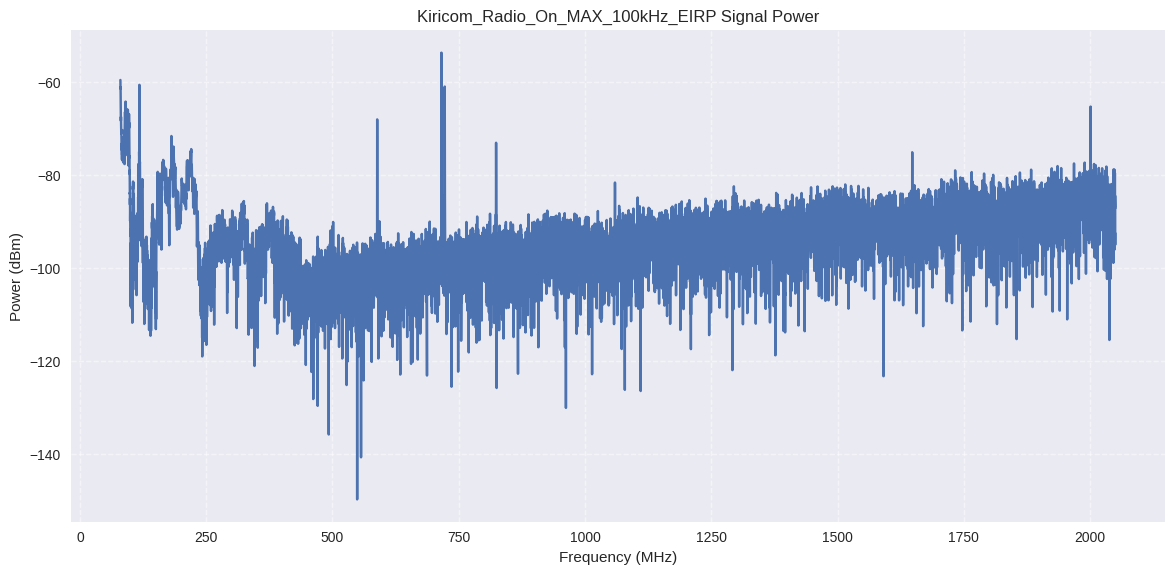

/tmp/ipykernel_3791/9437385.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


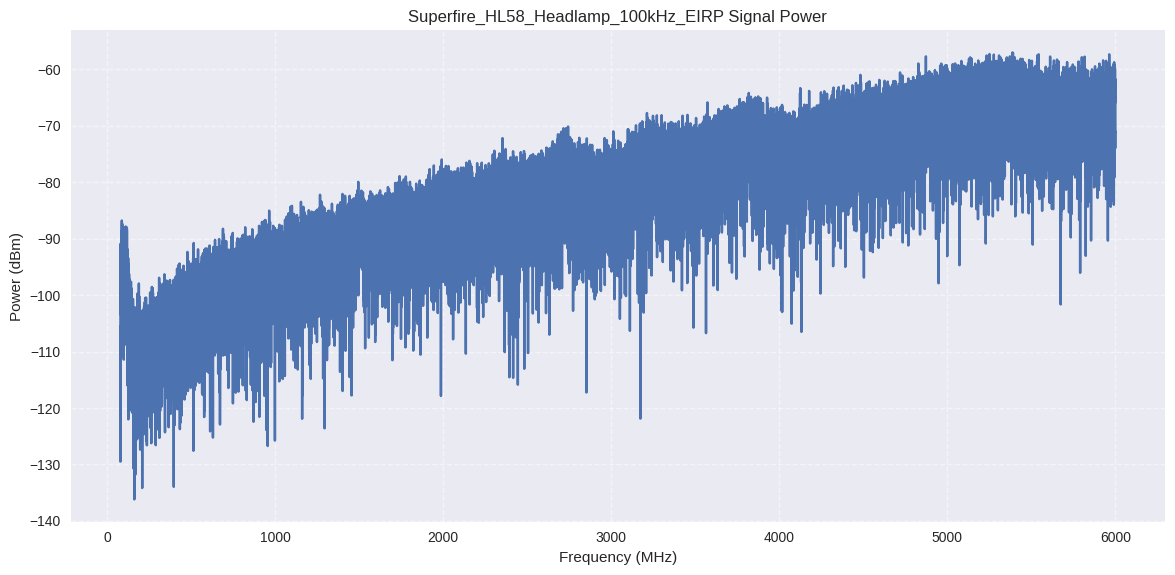

/tmp/ipykernel_3791/9437385.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


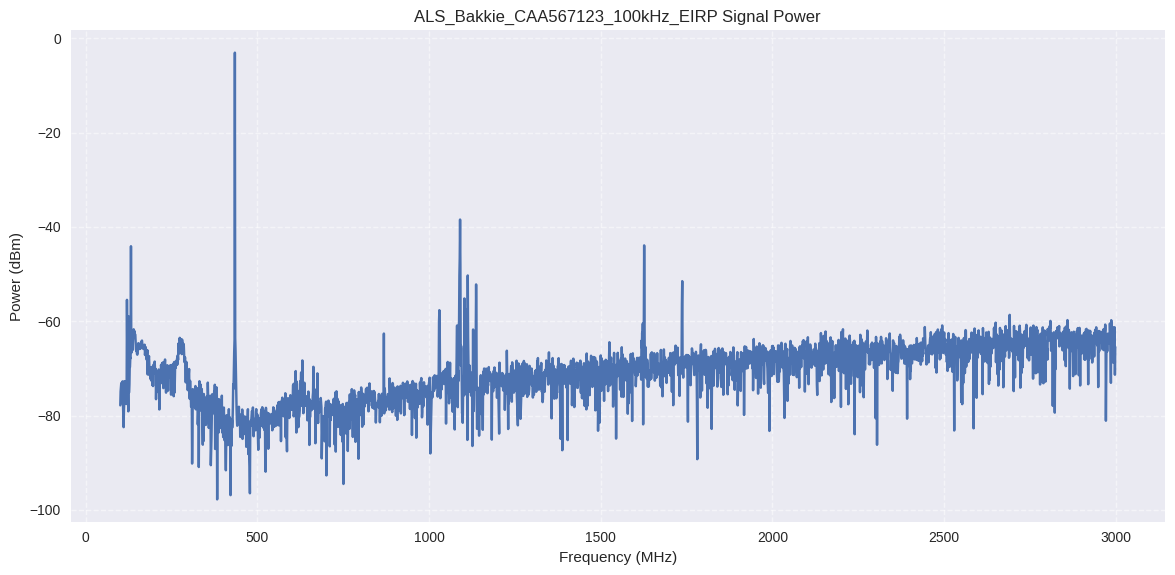

/tmp/ipykernel_3791/9437385.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


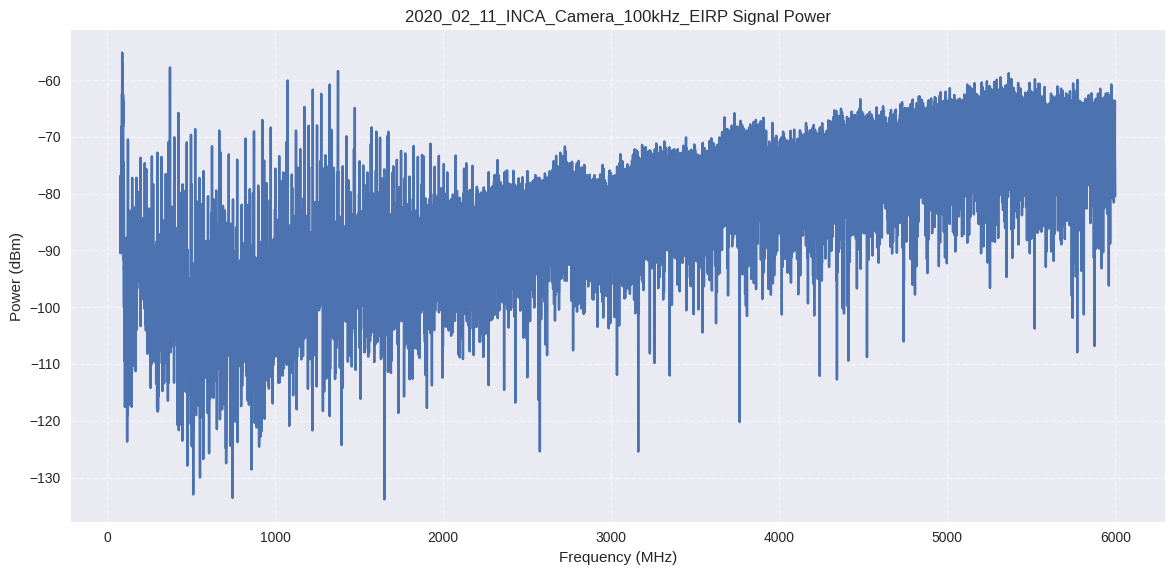

In [12]:

for instrument_name, df in dataframe_clean.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))

    
    

    # Plot with proper labels
    plt.plot(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'])
    

    # Format plot
    plt.title(f'{instrument_name} Signal Power')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Power (dBm)')
    #plt.xlim(50,350)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Determine the best polynomial order for the data

--> To determine the best polynomial order for fitting data (e.g., for detrending), use the Bayesian Information Criterion (BIC) — a standard method for model selection that balances fit quality with model complexity.

In [13]:

def calculate_bic(frequencies, signal, max_degree):
    """
    Calculate BIC values for polynomial fits of varying degrees
    
    Parameters:
    - frequencies: array-like, input frequency values
    - signal: array-like, signal power values
    - max_degree: int, maximum polynomial degree to test 
    
    Returns:
    - bics: list of BIC values for degrees 1..max_degree
    - optimal_degree: degree with minimum BIC
    """
    
    degrees = range(1, max_degree + 1)
    bics = []
    n = len(frequencies)
    
    for deg in degrees:
        # Fit polynomial
        coeffs = np.polyfit(frequencies, signal, deg)
        y_fit = np.polyval(coeffs, frequencies)
        
        # Residual sum of squares
        residuals = signal - y_fit
        rss = np.sum(residuals ** 2)
        
        # BIC calculation
        k = deg + 1  # Number of parameters
        bic = n * np.log(rss / n) + k * np.log(n)
        bics.append(bic)
    
    
    return bics, degrees

/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3

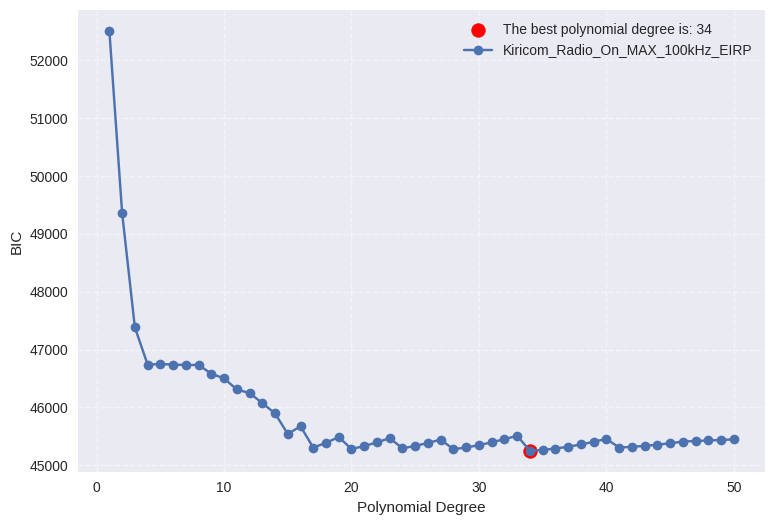

/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3

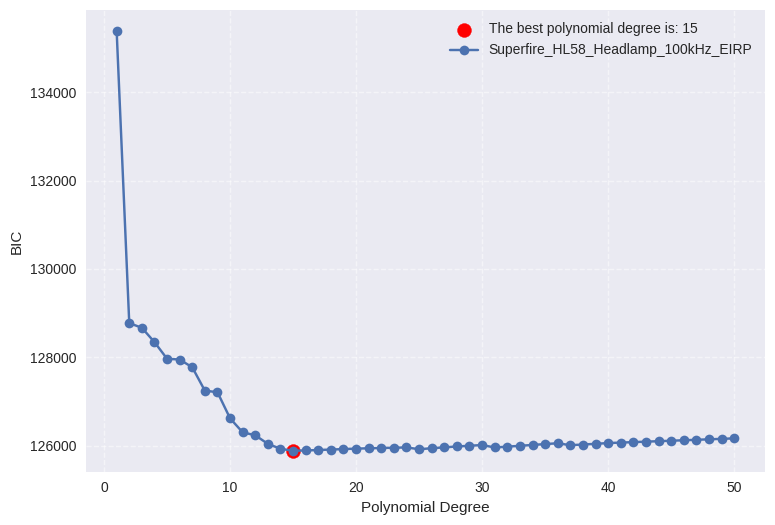

/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3

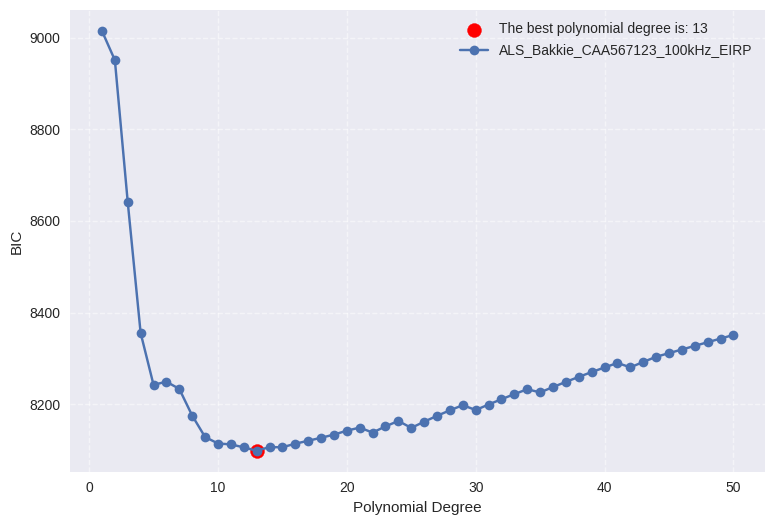

/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3791/4126888464.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3

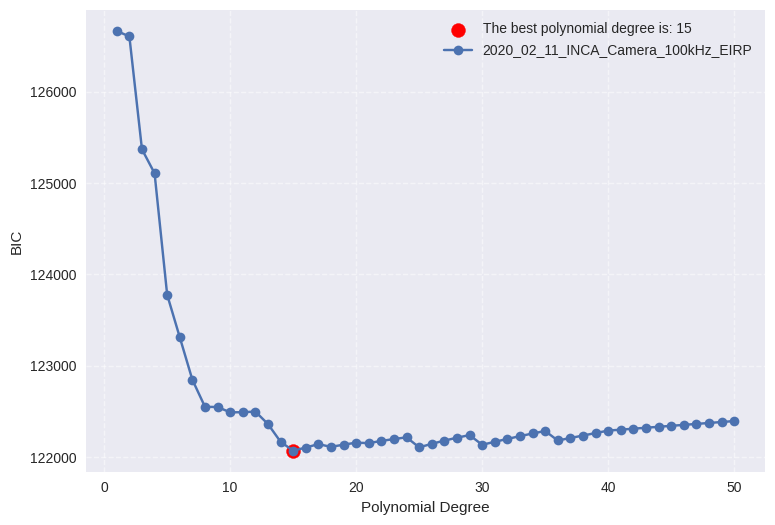

In [21]:
for instrument_name, df in dataframe_clean.items():

    # calculate the bic 
    bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)

    # Find optimal degree
    optimal_idx = np.argmin(bic)
    optimal_degree = degree[optimal_idx]

    # # Find the best degree
    # print(f'The best polynomial degree is: {optimal_degree}')

    
    plt.style.use('seaborn')
    plt.scatter(degree[optimal_idx], bic[optimal_idx], c='red', marker='o', s=100, label='The best polynomial degree is: '+str(optimal_degree))
    plt.plot(degree, bic, marker='o', label=instrument_name)
    plt.xlabel('Polynomial Degree')
    plt.ylabel('BIC')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()




Create different notebook for each detrented method.

Diferente note book for each step.

In [ ]:
#

# Define the best window legth for Savitzky-Golay filter.

In [17]:
def window_length(frequency, signal):
    """
    Analyze different window lengths to use Savitzky-Golay filters.
    
    Parameters:
        frequency (array): Frequency values
        signal (array): Signal values to analyze
        
    Returns:
        tuple: (trends, detrended_signals) containing all filtered results
    """
    # Configuration
    windows = [21, 31, 41, 51]
    polyorder = 3
    
    # Calculate trends and detrended signals
    trends = []
    detrend_signal = []
    
    for w in windows:
        trend = savgol_filter(signal, window_length=w, polyorder=polyorder)
        det = signal - trend
        trends.append(trend)
        detrend_signal.append(det)
    

    return trends, detrend_signal

In [23]:
dataframe_clean

{'Kiricom_Radio_On_MAX_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               0          80.0925       -59.478259
 1               1          80.1850       -61.157473
 2               2          80.2775       -61.318212
 3               3          80.3700       -60.994273
 4               4          80.4625       -61.422765
 ...           ...              ...              ...
 12797       21291        2049.5100       -87.196076
 12798       21292        2049.6025       -84.371832
 12799       21294        2049.7875       -86.330525
 12800       21295        2049.8800       -94.942077
 12801       21296        2049.9725       -92.431921
 
 [12802 rows x 3 columns],
 'Superfire_HL58_Headlamp_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               1          80.0925      -105.448569
 1               2          80.1850      -129.491156
 2               5          80.4625       -98.770357
 3               6          80.5550       -93.65

/tmp/ipykernel_3791/3738496732.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


ValueError: x and y must have same first dimension, but have shapes (12802,) and (4, 12802)

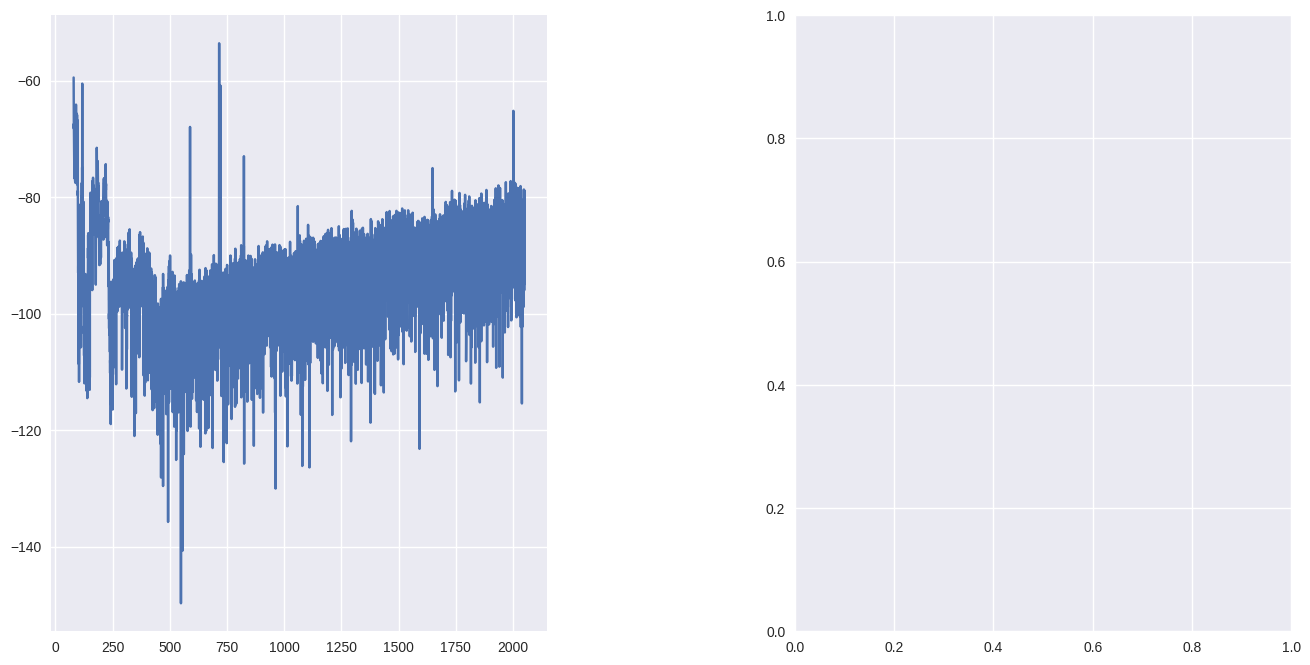

In [ ]:
for instrument_name, df in dataframe_clean.items():

    trend_sg, detrend_signal_sg = window_length(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'])

    plt.style.use('seaborn')
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    fig.subplots_adjust(wspace=0.5)

    axs[0].plot(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'])
    axs[0].plot(df['Frequency (MHz)'], trend_sg)

    axs[1].plot(df['Frequency (MHz)'],detrend_signal_sg)

    

In [25]:
trend_sg

[array([-59.67598966, -60.27594406, -60.9248624 , ..., -88.73432584,
        -91.07078942, -93.91744645]),
 array([-59.28569945, -60.16678555, -61.01267566, ..., -88.69073682,
        -89.99834983, -91.51813769]),
 array([-59.45790309, -60.26723727, -61.05392188, ..., -88.37368012,
        -89.23903183, -90.22695038]),
 array([-59.42389292, -60.2511175 , -61.05237774, ..., -87.66425944,
        -88.00182903, -88.37908924])]